In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch import optim
import random as rnd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm, trange
import os
from utils.svg import SVG
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import pandas as pd
from torchsummary import summary
import math
import utils.dataloader as dl
import shutil
import optuna
from optuna.trial import TrialState
from cairosvg import svg2png

from IPython import display
%matplotlib inline

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

SVG.ENCODE_HEIGHT = 80
# fonts_number = 100
fonts_number = 8000
# fonts_number = None

print(f'Device: {device}')

Device: cpu


## Загрузка данных

In [6]:
print('Loading data')
dl.load_data(fonts_number)

Loading data
<################################################################################>: 100.% [8000 / 8000]


In [7]:
print('Encoding data')
stored_path = Path(f'data/data_abs_{SVG.ENCODE_HEIGHT}_{fonts_number}.json')
if stored_path.exists():
    data = pd.read_json(str(stored_path))
    # data['data'] = data['data'].apply(lambda x: np.array(x))
else:
    data = dl.get_data(fonts_number)
    data.to_json(str(stored_path))
data

Encoding data
<################################################################################>: 100.% [8000 / 8000]

,font,letter,data
0,!crass_roots_ofl,a,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,!crass_roots_ofl,b,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,!crass_roots_ofl,c,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,!crass_roots_ofl,d,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,!crass_roots_ofl,e,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...
182056,letraslocas2,seven,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
182057,letraslocas2,t,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
182058,letraslocas2,v,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
182059,letraslocas2,x,"[[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


## Определение даталоадеров
`Dataloader` для букв

`DataloaderRows` для линий

In [8]:
class Dataloader:
    def __init__(self, df: pd.DataFrame, test_size=0.1, shuffle=False, batch_size=24):
        if shuffle:
            df = df.sample(frac=1).reset_index(drop=True)
        xs = np.array(df['data'].to_list(), dtype=np.float32)
        ys = df['letter'].to_numpy()
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(xs, ys, test_size=test_size, shuffle=shuffle)
        self.batch_size = batch_size

    def iterate(self):
        bs = self.batch_size
        for i in range(len(self.x_train) // bs):
            yield self.x_train[i * bs: (i + 1) * bs], self.y_train[i * bs: (i + 1) * bs]

    def iterate_test(self):
        yield self.x_test, self.y_test

    def __len__(self):
        return len(self.x_train) // self.batch_size + int(len(self.x_train) % self.batch_size > 0)
    
class DataloaderRows:
    def __init__(self, df: pd.DataFrame, test_size=0.1, shuffle=False, batch_size=24):
        if shuffle:
            df = df.sample(frac=1).reset_index(drop=True)
        xs = np.array(df['data'].to_list(), dtype=np.float32)
        xs = xs.reshape((-1, SVG.ENCODE_WIDTH))
        self.x_train, self.x_test = train_test_split(xs, test_size=test_size, shuffle=shuffle)
        self.batch_size = batch_size

    def iterate(self):
        bs = self.batch_size
        for i in range(len(self.x_train) // bs):
            yield self.x_train[i * bs: (i + 1) * bs]

    def iterate_test(self):
        yield self.x_test

    def __len__(self):
        return len(self.x_train) // self.batch_size + int(len(self.x_train) % self.batch_size > 0)
    

In [9]:
dataloader = Dataloader(data, test_size=0.15, shuffle=True)
dataloader_rows = DataloaderRows(data, test_size=0.15, shuffle=True)

In [10]:
def save_sampled(x: np.ndarray, name):
    file = Path('imgs') / name
    file.parent.mkdir(parents=True, exist_ok=True)
    svg = SVG.decode(x, path=file)
    svg.dump_to_file()
    
def show_sampled(x: np.ndarray):
    svg = SVG.decode(x)
    svg.mulsize(256)
    svg2png(bytestring=svg.dump(), write_to='imgs/tmp.png')
    img = mpimg.imread('imgs/tmp.png')
    plt.imshow(img)

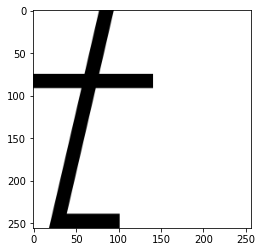

In [11]:
save_sampled(dataloader.x_test[0], 'test_print.svg')
show_sampled(dataloader.x_test[0])

## Определение рисователя прогресса

In [12]:
train_ts, train_loss = [], []
test_ts, test_loss = [], []
interval = len(dataloader) / 6

def show_progress(t, epochs, save_to=None, info: dict | None = None):
    display.clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, figsize=(12, 10))
    fig.suptitle(f'Epoch {t:3.3f} / {epochs}', fontsize=16)
    
    last_size = 0.5
    
    for ax, msg in zip((ax1, ax2), ('', f'last {int(last_size*100)}%')):
        title = f'loss {msg}'
        if info is not None:
            title += ' | ' + ' | '.join(f'{key}: {value}' for key, value in info.items())
        ax.set_title(title)
        ax.set_xlabel('time (epochs)')
        ax.set_ylabel('loss')
    last_train = str(train_loss[-1]) if len(train_loss) > 0 else ''
    last_test = str(test_loss[-1]) if len(test_loss) > 0 else ''
    
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3, label=f'train: {last_train}')
    ax1.plot(test_ts, test_loss, c='green', marker='o', lw=5, label=f'test: {last_test}')
    
    ax2.plot(train_ts[-int(len(train_ts)*last_size):], train_loss[-int(len(train_loss)*last_size):], c='darkblue', lw=3, label=f'train: {last_train}')
    ax2.plot(test_ts[-int(len(test_ts)*last_size):], test_loss[-int(len(test_loss)*last_size):], c='green', marker='o', lw=5, label=f'test: {last_test}')
    
    ax1.legend()
    ax2.legend()
    if save_to is None:
        plt.show() 
    else:
        plt.savefig(save_to)
        plt.close()


## Определение энкодеров
`AE` - автоэнкодер

`CAE` - автоэнкодер с условием

In [13]:
class BnAndDropout(nn.Module):
    def __init__(self, features, p=0.15):
        super().__init__()
        self.bn = nn.BatchNorm1d(num_features=features)
        self.do = nn.Dropout(p)
    
    def forward(self, x):
        return self.do(self.bn(x))


class Block(nn.Module):
    def __init__(self, f_in, f_out):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(f_in, f_out),
            nn.Tanh(),
            # BnAndDropout(f_out),
        )

    def forward(self, x):
        return self.layer(x)


class TimeBlock(nn.Module):
    def __init__(self, f_in, f_out, time_emb_dim):
        super().__init__()
        self.time_mlp = nn.Sequential(
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
        )
        self.layer = nn.Sequential(
            nn.Linear(f_in + time_emb_dim, f_out),
            nn.Tanh(),
            # BnAndDropout(f_out),
        )

    def forward(self, x, t):
        t = self.time_mlp(t)
        x = torch.cat((x, t), dim=1)
        return self.layer(x)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


In [14]:
class AE(nn.Module):
    def __init__(self, params):
        super().__init__()
        
        self.encode = True
        self.decode = True
        
        self.encoder = []
        for i in range(len(params) - 1):
            self.encoder.append(Block(params[i], params[i + 1]))
        
        self.decoder = []
        for i in range(len(params) - 1, 0, -1):
            self.decoder.append(Block(params[i], params[i - 1]))
        
        self.encoder = nn.Sequential(*self.encoder)
        self.decoder = nn.Sequential(*self.decoder)
        
    def forward(self, x):
        if self.encode:
            x = self.encoder(x)
        if self.decode:
            x = self.decoder(x)
        return x

    def loss(self):
        def _inner(y_hat, y):
            return ((y - y_hat)**2).mean(axis=0).sum()

        return _inner

    def train_fn(self, epoch, epochs, dataloader, loss_fn, optimizer, scheduler, pbar=None, show=True):
        self.train()
        num_batches = len(dataloader)
        for batch, inp_data in enumerate(dataloader.iterate()):
            inp_data = torch.Tensor(inp_data).to(device)

            output = self(inp_data)
            loss = loss_fn(output, inp_data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % interval == 0:
                t = epoch + (batch + 1) / num_batches
                train_ts.append(t)
                train_loss.append(loss.item())
                if show:                
                    show_progress(t, epochs, info={'lr': scheduler.get_last_lr()[0]})
                if pbar is not None:
                    pbar.refresh()
        scheduler.step()

    @torch.no_grad()
    def test_fn(self, epoch, epochs, dataloader, loss_fn, show=True):
        self.eval()
        num_batches = len(dataloader)
        tmp_test_loss = []
        for images in dataloader.iterate_test():
            images = torch.Tensor(images).to(device)

            decoded = self(images)
            loss = loss_fn(decoded, images)

            tmp_test_loss.append(loss.item())

        test_ts.append(epoch)
        test_loss.append(np.mean(tmp_test_loss))
        if show:
            show_progress(epoch, epochs)

In [15]:
class CAE(nn.Module):
    def __init__(self, params, in_labels, time_emb_dim=32):
        super().__init__()
        
        encoder_params = params[:]
        encoder_params[0] += in_labels
        
        decoder_params = params[::-1]
        decoder_params[0] += in_labels

        self.encoder = []
        for i in range(len(encoder_params) - 1):
            self.encoder.append(TimeBlock(encoder_params[i], encoder_params[i + 1], time_emb_dim))
        
        self.decoder = []
        self.decoder.append(Block(decoder_params[0], decoder_params[1]))
        for i in range(1, len(decoder_params) - 1):
            self.decoder.append(TimeBlock(decoder_params[i] * 2, decoder_params[i + 1], time_emb_dim))

        self.encoder = nn.ParameterList(self.encoder)
        self.decoder = nn.ParameterList(self.decoder)
        
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
        )
        
    def forward(self, x, labels, timestep):
        shape = x.shape
        t = self.time_mlp(timestep)
        x = x.view(shape[0], -1)
        x = torch.cat((x, labels), 1)
        accumulate = []
        for layer in self.encoder:
            x = layer(x, t)
            accumulate.append(x)
        accumulate.pop()
        
        x = torch.cat((x, labels), 1)
        x = self.decoder[0](x)
        
        for layer in self.decoder[1:]:
            connection = accumulate.pop()
            x = torch.cat((x, connection), 1)
            x = layer(x, t)
        x = x.view(shape[0], shape[1], -1)
        
        return x
    
    def loss(self):
        def _inner(y_hat, y):
            return ((y - y_hat)**2).mean(axis=0).sum()

        return _inner
    
    def train_fn(self, epoch, epochs, dataloader, loss_fn, optimizer, scheduler, pbar=None, show=True):
        self.train()
        num_batches = len(dataloader)
        for batch, (inp_data, labels) in enumerate(dataloader.iterate()):
            inp_data = torch.Tensor(inp_data).to(device)
            labels = labels2one_hot(labels).to(device)
            t = torch.zeros([len(labels)]).to(device)

            output = self(inp_data, labels, t)
            loss = loss_fn(output, inp_data)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % interval == 0:
                t = epoch + (batch + 1) / num_batches
                train_ts.append(t)
                train_loss.append(loss.item())
                if show:                
                    show_progress(t, epochs, info={'lr': scheduler.get_last_lr()[0]})
                if pbar is not None:
                    pbar.refresh()
        scheduler.step()        

    @torch.no_grad()
    def test_fn(self, epoch, epochs, dataloader, loss_fn, show=True):
        self.eval()
        tmp_test_loss = []
        for inp_data, labels in dataloader.iterate_test():
            inp_data = torch.Tensor(inp_data).to(device)
            labels = labels2one_hot(labels).to(device)
            t = torch.zeros([len(labels)], dtype=torch.int64).to(device)

            result = self(inp_data, labels, t)
            loss = loss_fn(result, inp_data)

            tmp_test_loss.append(loss.item())

        test_ts.append(epoch)
        test_loss.append(np.mean(tmp_test_loss))
        if show:
            show_progress(epoch, epochs)

## Вспомогательные функции

In [18]:
ONE_HOT_LEN = len(dl.GLYPH_FILTER)
one_hot_rules = {
    glyph: one_hot
    for glyph, one_hot in zip(
        dl.GLYPH_FILTER, 
        range(0, ONE_HOT_LEN),
    )
}

def labels2num(labels):
    return torch.Tensor([one_hot_rules[i] for i in labels]).long()

def labels2one_hot(labels):
    return F.one_hot(labels2num(labels), num_classes=ONE_HOT_LEN)

In [19]:
epoch = 0

def run(model, dataloader, optimizer, scheduler, epochs, params, batch_size, _epoch=0, run_name=None, trial=None):
    global epoch

    class_name = model.__class__.__name__
    if run_name is None:
        run_name = f'run_size{SVG.ENCODE_HEIGHT}_{class_name}_{",".join(map(str, params))}'

    save_folder = Path(f'models_{class_name}') / run_name
    loss_img_path = str(save_folder / '_loss.png')
    save_folder.mkdir(parents=True, exist_ok=True)
    plt.clf()
    file_format = 'svg'
    max_epoch = epoch + epochs
    loss_fn = model.loss()
    dataloader.batch_size = batch_size

    if trial is None:
        pbar = trange(epoch, max_epoch)
        rng = pbar
    else:
        pbar = None
        rng = range(epoch, max_epoch)
    for _epoch in rng:
        model.train_fn(_epoch, max_epoch, dataloader, loss_fn, optimizer, scheduler, pbar, show=trial is None)
        model.test_fn(_epoch + 1, max_epoch, dataloader, loss_fn, show=trial is None)

        torch.save(model.state_dict(), save_folder / 'ckpt.pt')

        if trial is not None:
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        else:
            epoch = _epoch + 1
        show_progress(_epoch + 1, max_epoch, loss_img_path, info={'params':params, 'lr': scheduler.get_last_lr()[0]})
    

In [20]:
def setup_maker(model_type):
    is_cae =  model_type == 'cae'
    model_char = 'c' if is_cae else ''

    def _inner(params, lr, weight_decay=2e-5, step_size=1):
        global train_ts, train_loss, test_ts, test_loss, epoch

        if is_cae:
            model = CAE(params, ONE_HOT_LEN).to(device)
        else:
            model = AE(params).to(device)
            
        loss_fn = model.loss()
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.95)

        train_ts, train_loss = [], []
        test_ts, test_loss = [], []
        epoch = 0

        return model, optimizer, scheduler, loss_fn

    return _inner
    
setup_cae = setup_maker('cae')
setup_ae = setup_maker('ae')

## Поиск конфигурации модели для кодирования линий

In [ ]:
def run_for_search(trial):
    lr = trial.suggest_float('lr', 1e-6, 1e-3, log=True)
    params = [
        SVG.ENCODE_WIDTH,
        trial.suggest_int('p1', 10, 25),
        trial.suggest_int('p2', 8, 20),
        trial.suggest_int('p3', 4, 10),
    ]

    for i in range(3):
        params.append(trial.suggest_int(f'p{i}', 4, 20))
    
    model, optimizer, scheduler, loss_fn = setup_ae(
        params=params,
        lr=lr,
        weight_decay=5e-5,
    )
    run(
        model=model, 
        dataloader=dataloader_rows, 
        optimizer=optimizer,
        scheduler=scheduler,
        epochs=4,
        params=params,
        batch_size=2048,
        run_name='temp',
        trial=trial,
    )
    return test_loss[-1] + max(test_loss[-1] - train_loss[-1], 0) ** 2 


study = optuna.create_study(
    direction="minimize",
    storage="sqlite:///db.sqlite3",
    study_name="ae_lr_3_layers_4_epoch"
)

study.optimize(run_for_search, n_trials=50, show_progress_bar=True)

## Обучаем кодировщик линий

In [21]:
LINE_WIDTH = 12
params = [SVG.ENCODE_WIDTH, 19, 15, LINE_WIDTH]

model_rows, optimizer_rows, scheduler_rows, loss_fn_rows = setup_ae(
    params=params,
    lr=6e-4,
    weight_decay=3e-6,
)

In [22]:
run(
    model=model_rows, 
    dataloader=dataloader_rows,
    optimizer=optimizer_rows,
    scheduler=scheduler_rows,
    epochs=10,
    params=params,
    batch_size=1024,
)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [13:13<00:00, 79.34s/it]


## Декодировать, нарисовать

In [23]:
def decode_img(d):
    model_rows.decode = True
    model_rows.encode = False
    model_rows.eval()
    with torch.no_grad():
        origin = model_rows(d)
        model_rows.encode = True
        return origin.cpu().detach().numpy()

def encode_img(d):
    model_rows.decode = False
    model_rows.encode = True
    model_rows.eval()
    with torch.no_grad():
        image = model_rows(d)
        model_rows.decode = True
        return image.cpu().detach().numpy()


## Кодируем все линии в датасете

In [24]:
encoded = []
to_encode = np.array(data['data'].to_list(), dtype=np.float32)
for image in tqdm(to_encode):
    image = torch.Tensor(image).to(device)
    encoded.append(encode_img(image))
        
enc_data = data.copy()
enc_data['data'] = encoded

enc_dataloader = Dataloader(enc_data, test_size=0.15, shuffle=True)

model_rows.decode = True

100%|████████████████████████████████████████████████████████████████████████| 182061/182061 [01:25<00:00, 2125.76it/s]


C:\Users\flydzen\AppData\Local\Temp/ipykernel_14808/3129551380.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


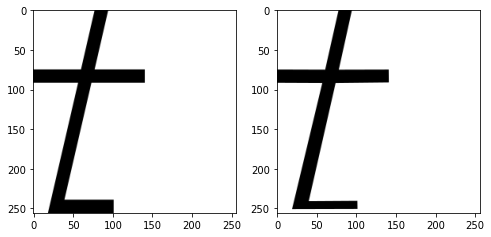

In [25]:
original_img = dataloader.x_test[0]
encoded_img = encode_img(torch.Tensor(original_img).to(device))
processed_img = decode_img(torch.Tensor(encoded_img).to(device))

plt.figure(figsize=(8, 8))
plt.axis('off')

plt.subplot(1, 2, 1)
save_sampled(original_img, 'origin.svg')
show_sampled(original_img)
plt.subplot(1, 2, 2)
save_sampled(processed_img, 'processed.svg')
show_sampled(processed_img)

## Дифузионная модель

In [26]:
class Diffusion:
    def __init__(self, model):
        self.T = 300
        self.betas = self.linear_beta_schedule(timesteps=self.T)

        # Pre-calculate different terms for closed form
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
        
        self.model = model
    
    @staticmethod
    def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
        return torch.linspace(start, end, timesteps)

    @staticmethod
    def get_index_from_list(vals, t, x_shape):
        """ 
        Returns a specific index t of a passed list of values vals
        while considering the batch dimension.
        """
        batch_size = t.shape[0]
        out = vals.gather(-1, t.cpu())
        return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

    def forward_diffusion_sample(self, x_0, t):
        """ 
        Takes an image and a timestep as input and 
        returns the noisy version of it
        """
        noise = torch.randn_like(x_0).to(device)
        sqrt_alphas_cumprod_t = self.get_index_from_list(self.sqrt_alphas_cumprod, t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(
            self.sqrt_one_minus_alphas_cumprod, t, x_0.shape
        )
        # mean + variance
        return sqrt_alphas_cumprod_t * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t * noise, noise

    def get_loss(self, x_0, labels, t):
        x_noisy, noise = self.forward_diffusion_sample(x_0, t)
        noise_pred = self.model(x_noisy, labels, t)
        return F.l1_loss(noise, noise_pred)

    @torch.no_grad()
    def sample_timestep(self, x, labels, t):
        """
        Calls the model to predict the noise in the image and returns 
        the denoised image. 
        Applies noise to this image, if we are not in the last step yet.
        """
        betas_t = self.get_index_from_list(self.betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = self.get_index_from_list(
            self.sqrt_one_minus_alphas_cumprod, t, x.shape
        )
        sqrt_recip_alphas_t = self.get_index_from_list(self.sqrt_recip_alphas, t, x.shape)

        # Call model (current image - noise prediction)
        model_mean = sqrt_recip_alphas_t * (
            x - betas_t * self.model(x, labels, t) / sqrt_one_minus_alphas_cumprod_t
        )
        posterior_variance_t = self.get_index_from_list(self.posterior_variance, t, x.shape)

        if t == 0:
            return model_mean
        else:
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise 

    @torch.no_grad()
    def sample_plot_image(self):
        # Sample noise
        img = torch.randn((1, SVG.ENCODE_HEIGHT, LINE_WIDTH), device=device)
        label_ind = rnd.randrange(ONE_HOT_LEN)
        label = torch.zeros((1, ONE_HOT_LEN), dtype=torch.float32)
        plt.figure(figsize=(15,15))
        plt.axis('off')
        num_images = 10
        stepsize = int(self.T / num_images)

        for i in range(0, self.T)[::-1]:
            t = torch.full((1,), i, device=device, dtype=torch.int64)
            img = self.sample_timestep(img, label, t)
            print(img.shape)
            if i % stepsize == 0:
                plt.subplot(1, num_images, i // stepsize + 1)
                show_sampled(decode_img(img[0]))
        plt.show()
    
    def train_fn(self, epoch, epochs, dataloader, loss_fn, optimizer, scheduler, pbar=None, show=True):
        self.model.train()
        num_batches = len(dataloader)
        for batch, (inp_data, labels) in enumerate(dataloader.iterate()):
            inp_data = torch.Tensor(inp_data).to(device)
            labels = labels2one_hot(labels).to(device)
            t = torch.randint(0, self.T, [len(labels)], device=device).long()
            
            optimizer.zero_grad()

            loss = self.get_loss(inp_data, labels, t)
            loss.backward()
            optimizer.step()

            if batch % interval == 0:
                t = epoch + (batch + 1) / num_batches
                train_ts.append(t)
                train_loss.append(loss.item())
                if show:                
                    show_progress(t, epochs, info={'lr': scheduler.get_last_lr()[0]})
                if pbar is not None:
                    pbar.refresh()
        scheduler.step()        

    @torch.no_grad()
    def test_fn(self, epoch, epochs, dataloader, loss_fn, show=True):
        self.model.eval()
        tmp_test_loss = []
        for inp_data, labels in dataloader.iterate_test():
            inp_data = torch.Tensor(inp_data).to(device)
            labels = labels2one_hot(labels).to(device)
            t = torch.randint(0, self.T, [len(labels)], device=device).long()
            
            loss = self.get_loss(inp_data, labels, t)
            tmp_test_loss.append(loss.item())

        test_ts.append(epoch)
        test_loss.append(np.mean(tmp_test_loss))
        if show:
            # show_progress(epoch, epochs)
            self.sample_plot_image()
            
    def loss(self):
        return None
    
    def state_dict(self):
        return self.model.state_dict()

C:\Users\flydzen\AppData\Local\Temp/ipykernel_14808/874398062.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images + 1, (idx // stepsize) + 1)


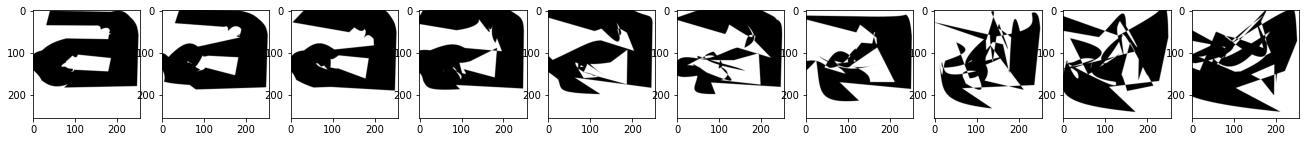

In [27]:
diffusion = Diffusion(None)

image = torch.Tensor(enc_dataloader.x_test[1]).to(device)

plt.figure(figsize=(25, 20))
plt.axis('off')
num_images = 10

# stepsize = diffusion.T // num_images
stepsize = 1

# for idx in range(0, diffusion.T, stepsize):
for idx in range(0, 10):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images + 1, (idx // stepsize) + 1)
    image, noise = diffusion.forward_diffusion_sample(image, t)
    decoded_svg = decode_img(image)
    show_sampled(decoded_svg)

In [30]:
params = [SVG.ENCODE_HEIGHT * LINE_WIDTH, 2350, 2300, 1640, 1128, 494]

model, optimizer, scheduler, loss_fn = setup_cae(
    params=params,
    lr=2e-4,
    weight_decay=2e-5,
)

diffusion = Diffusion(model)

<Figure size 432x288 with 0 Axes>

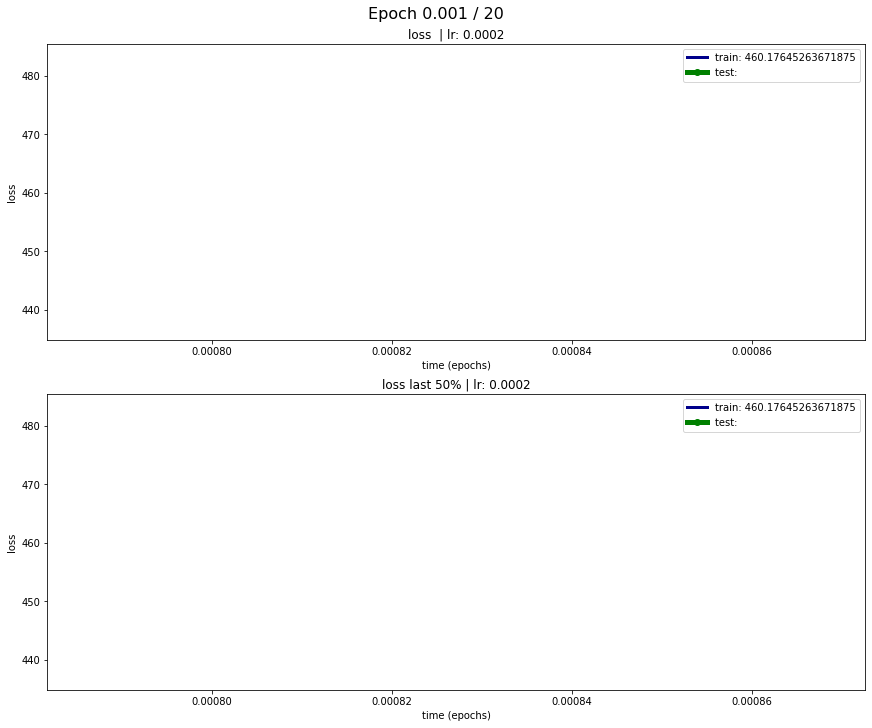

  0%|                                                                                           | 0/20 [19:33<?, ?it/s]


KeyboardInterrupt: 

In [31]:
run(
    model=model, 
    dataloader=enc_dataloader, 
    optimizer=optimizer, 
    scheduler=scheduler, 
    epochs=20,
    params=params,
    batch_size=128,
)

In [ ]:
# epoch = 0
run(
    model=diffusion, 
    dataloader=enc_dataloader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    epochs=20,
    params=params,
    batch_size=128,
    # run_name=f'run_diffusion_size{SVG.ENCODE_HEIGHT}_{",".join(map(str, params))}',
)